
In this notebook, we present solutions for Task 4 using a different quantum model. We implemented the proposed model from article [Schuld, Maria et.al "The effect of data encoding on the expressive power of variational quantum machine learning models"](https://arxiv.org/abs/2008.08605). Subsequently, we extend the task and train the model on a more complex function. We visualize our results with plots and demonstrate that this model effectively learns more complex functions.

<a id="0"></a>
1. [Ansatz](#1)
2. [Training](#2)
3. [Training for more complicated function](#3)
   1. [Experiment 1](#4)
   2. [Experiment 2](#5)
   3. [Experiment 3](#6)
   4. [Experiment 4](#7)

<a id="1"></a>
## Ansatz
Here we slightly modify the model. The system is in exactly the same form as proposed in the article [Schuld, Maria et.al "The effect of data encoding on the expressive power of variational quantum machine learning models"](https://arxiv.org/abs/2008.08605).
We used a (univariate) quantum model $f_{\theta}(x)$ and follow the assumption that overall quantum circuit has the form:
$$U(x) = W^{(L+1)} S(x) W^{(L)} ... W^{(2)} S(x) W^{(1)}$$

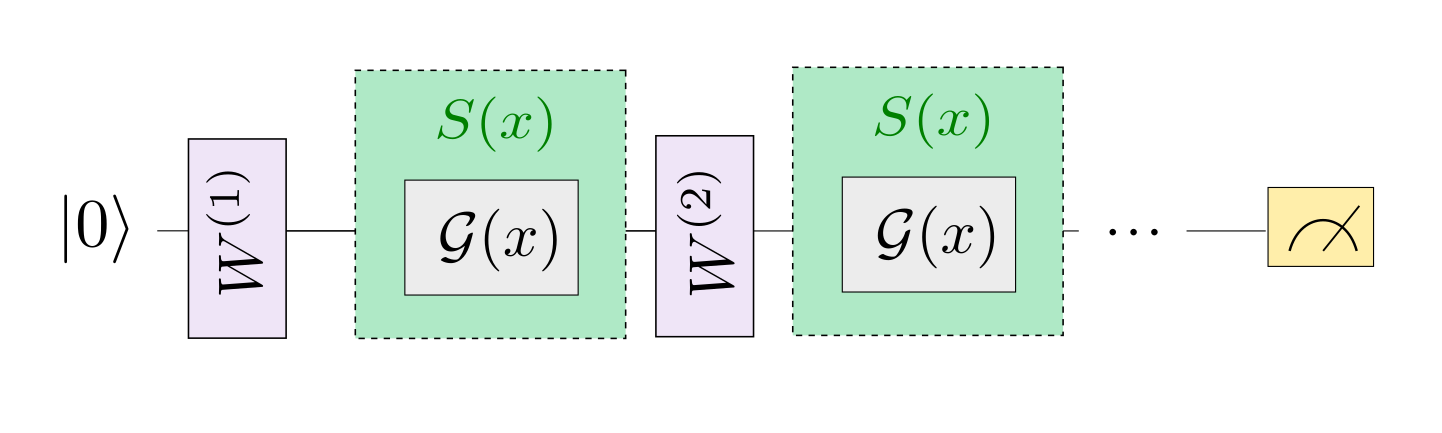
At this figure we see that our model is splitted into `data encoding (circuit) block1` $S(x)$ and `trainable (circuit) block` $W$. We use popular strategy of encoding an input single-qubit rotations.
Our variational circuit is of the form $$f_\theta(x) = \langle 0 | U^\dagger(x, \theta) M U(x, \theta) | 0 \rangle$$
,where $|0 \rangle$ is a single qubit, $M = \sigma_z $, and $$U(x,\theta) = W^{(2)}R_x(x)W^{(1)}$$.


(<Figure size 600x200 with 1 Axes>, <Axes: >)

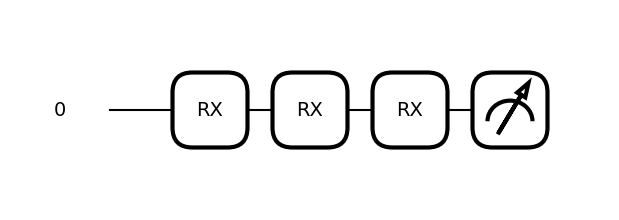

In [1]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def quantum_circuit(x,weights):
    # W(θ)
    qml.RX(weights[0], wires=0)
    # S(x)
    qml.RX(x, wires=[0])
    # W(θ)
    qml.RX(weights[1], wires=0)
    return qml.expval(qml.PauliZ(wires=0))

weights = [0.2,0.3]
x_input = [0.2]
quantum_circuit(x_input,weights)
qml.draw_mpl(quantum_circuit)(x_input,weights)

<a id="2"></a>
## Training
In this section, we perform the training process of the above model. Below, we see the Mean Squared Error (MSE) cost function. We use the following hyperparameters for training:
* `num_epochs = 30`
* `opt = qml.GradientDescentOptimizer(stepsize=0.1)`
* `init_params = np.array([0.1, 0.1], requires_grad=True)`

The hyperparameters are the same as in the previous notebook for the same data.

In [2]:
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss = loss + (t - p) ** 2
    loss = loss / len(targets)
    return loss

def cost(weights, x, y):
    predictions = [quantum_circuit(x=x_,weights=weights) for x_ in x]
    return square_loss(y, predictions)

In [3]:
import pennylane as qml
import pennylane.numpy as np
from modules.utils import create_data_sin_function
from modules.training import training

X_train, Y_train, X_test, Y_test = create_data_sin_function(1000)

num_epochs = 30
opt = qml.GradientDescentOptimizer(stepsize=0.1)
init_params = np.array([0.1, 0.1], requires_grad=True)
final_params,costs = training(num_epochs, opt,cost,init_params, X_train, Y_train)

Y_train: Length: 800
Y_test: Length: 200
Epoch: 0 | Cost: 1.0194214
Epoch: 1 | Cost: 0.8175566
Epoch: 2 | Cost: 0.6253504
Epoch: 3 | Cost: 0.4572690
Epoch: 4 | Cost: 0.3215243
Epoch: 5 | Cost: 0.2191139
Epoch: 6 | Cost: 0.1458961
Epoch: 7 | Cost: 0.0955804
Epoch: 8 | Cost: 0.0619426
Epoch: 9 | Cost: 0.0398639
Epoch: 10 | Cost: 0.0255433
Epoch: 11 | Cost: 0.0163237
Epoch: 12 | Cost: 0.0104154
Epoch: 13 | Cost: 0.0066396
Epoch: 14 | Cost: 0.0042305
Epoch: 15 | Cost: 0.0026949
Epoch: 16 | Cost: 0.0017165
Epoch: 17 | Cost: 0.0010933
Epoch: 18 | Cost: 0.0006964
Epoch: 19 | Cost: 0.0004436
Epoch: 20 | Cost: 0.0002826
Epoch: 21 | Cost: 0.0001800
Epoch: 22 | Cost: 0.0001147
Epoch: 23 | Cost: 0.0000731
Epoch: 24 | Cost: 0.0000465
Epoch: 25 | Cost: 0.0000297
Epoch: 26 | Cost: 0.0000189
Epoch: 27 | Cost: 0.0000120
Epoch: 28 | Cost: 0.0000077
Epoch: 29 | Cost: 0.0000049
Final parameters:  [-0.78384171 -0.78384171]


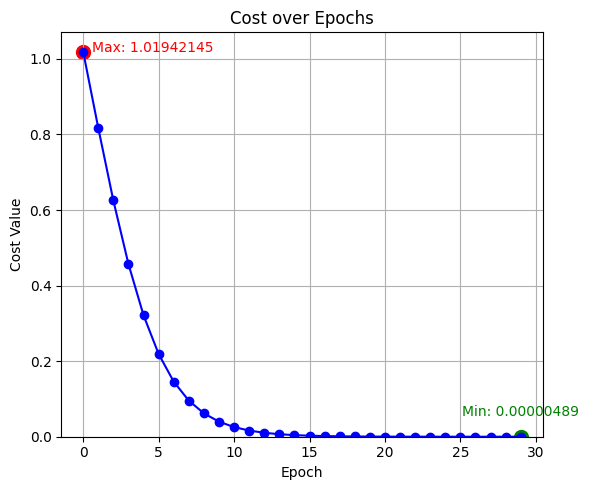

In [4]:
from modules.utils import plot_metrics_over_epochs
metrics_dict = {
    'Cost': costs
}
plot_metrics_over_epochs(metrics_dict)

Both training processes (compare the training proces in the previous notebook) utilize the same training dataset consisting of 800 samples. The number of epochs, optimizer, learning step size, and parameter initialization were conducted in an identical manner for both experiments.
By maintaining the same training data and hyperparameters, we want to conduct a comparison of the two circuits.

* Both circuits effectively minimized the cost function over the 30 epochs, demonstrating a successful training process.
* The cost values in both logs decrease significantly, indicating that the training process is effectively minimizing the cost function.
* Final Cost Values:
    - previous circuit (Circuit 1) training process ends with a final cost of 0.0000065
    - above circuit (Circuit 2) training process ends with a final cost of 0.0000042
* Metrics:
    - mean Cost (Circuit 1): 0.12396128333333335
    - mean Cost (Circuit 2): 0.12861971333333333
    - standard deviation of Cost (Circuit 1): 0.25247594098020126
    - standard Deviation of Cost (Circuit 2): 0.2532554523253833
* Final parameters:
    - Circuit 1 parameters are [-0.78357105, -0.78357105]
    - Circuit 2 parameters are [-0.78366153, -0.78366153]
    - the absolute differences between the corresponding parameters of the two circuits are [9.048e-5, 9.048e-5]

The analysis shows that both quantum circuits have successfully learned the sine function. The mean cost and standard deviation of cost are similar for both circuits, indicating they perform equally well and train stably. The tiny differences between the final parameters suggest that both circuits ended up with nearly the same solution


Cost (MSE) for training set: 0.0000049
Cost (MSE) for test set: 0.0000047


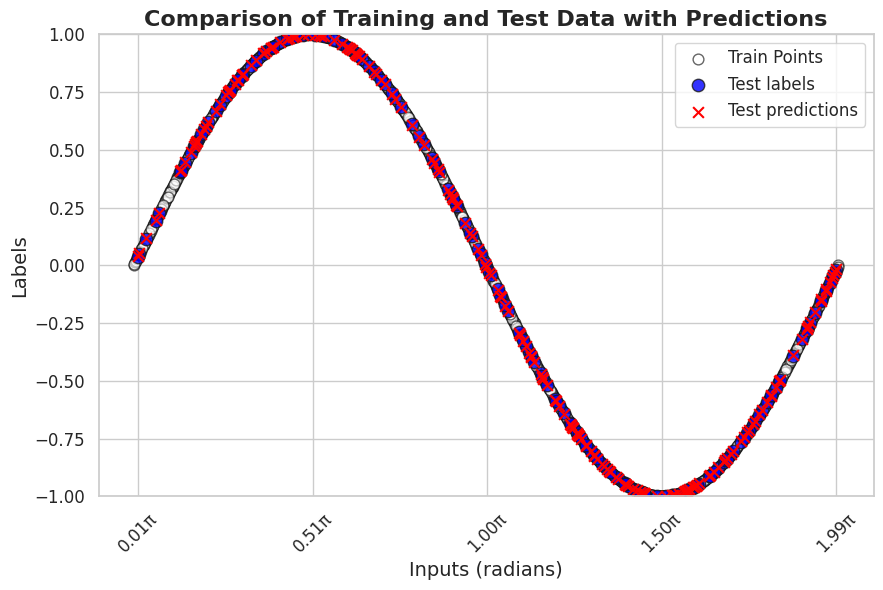

In [5]:
from modules.utils import plot_result
test_cost = cost(final_params, X_test, Y_test)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = predictions = [quantum_circuit(x=x_,weights=final_params) for x_ in X_test]

plot_result("Comparison of Training and Test Data with Predictions", X_test, Y_test, "Test labels", test_predictions, X_train, Y_train,shuffle=True)

Similar to the previous model, we achieved excellent fitting accuracy.
Unfortunately, our model is only capable of learning a sine function. If we apply it to a more complex function, the model will fail.
Additional explanation can be found in the previous file and in the articles [Schuld, Maria et.al "The effect of data encoding on the expressive power of variational quantum machine learning models"](https://arxiv.org/abs/2008.08605) [Patrick Holzer,Ivica Turkalj "Spectral Invariance and Maximality Properties of the Frequency Spectrum of Quantum Neural Networks"](https://arxiv.org/abs/2402.14515).

Regardless of the weights chosen, the single-qubit model for L=1 will always produce a sine function with a fixed frequency. The weights only affect the amplitude, vertical shift, and phase of the sine wave.
This observation is formally derived in Section II.A of the paper.

The logs of this training are saved in the file `2_Training_Process_Sin_function.txt` in folder `experiments`.

<a id="3"></a>
## Training for more complicated function
Based on observation from article, we evaluate the performance of this model on functions with a larger frequency spectrum. In the previous notebook, we observed that a single Pauli-rotation encoding can only approximate a sine function. We have implemented the quantum model strictly following the methodology from the referenced article. We are using a 5-layer sequential architecture. The complete circuit is available in the file `Circuit2`.


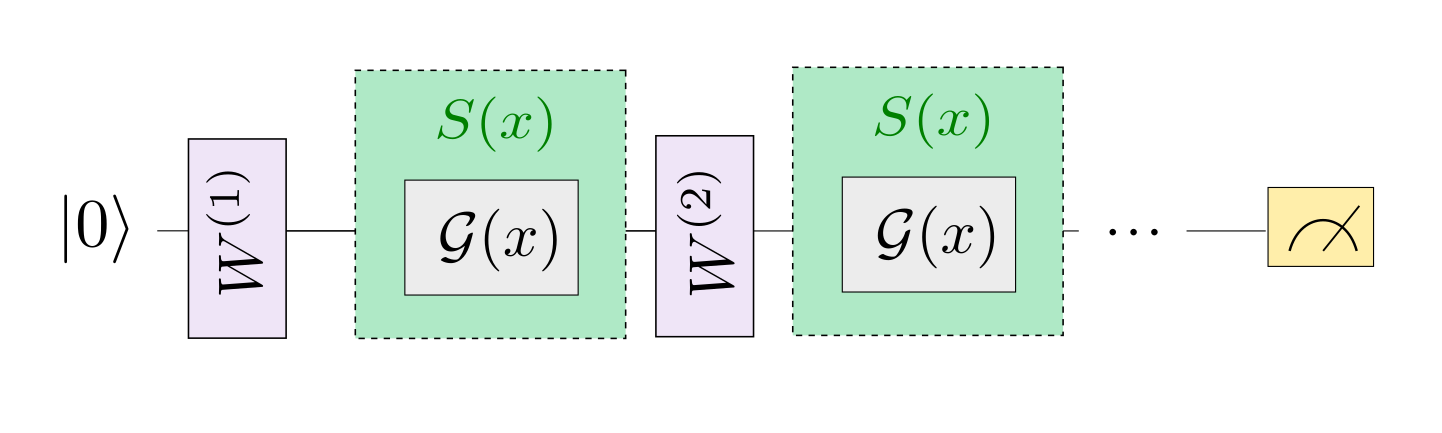

Our variational circuit is of the form $$f_\theta(x) = \langle 0 | U^\dagger(x, \theta) M U(x, \theta) | 0 \rangle$$
,where $|0 \rangle$ is a single qubit, $M = \sigma_z $, and.
$$U(x, \theta) = W_{\theta}^{(L+1)} \underbrace{S_L(x) W_{\theta}^{(L)}}_{\text{Layer L}} \cdots W_{\theta}^{(2)} \underbrace{S_1(x) W_{\theta}^{(1)}}_{\text{Layer 1}}$$

,where $S(x) = e^{-ixH} = R_x(\phi)$ and $W_{\theta} = RZ{(\omega)}RY{(\theta)}RZ{(\phi)}$.

The quantum circuit itself is constructed from $L$ layers, each consisting of a `data encoding circuit block` $S(x)$ and a `trainable circuit block` $W_{\theta}$ controlled by parameters $\theta$. The data encoding block is the same in every layer.

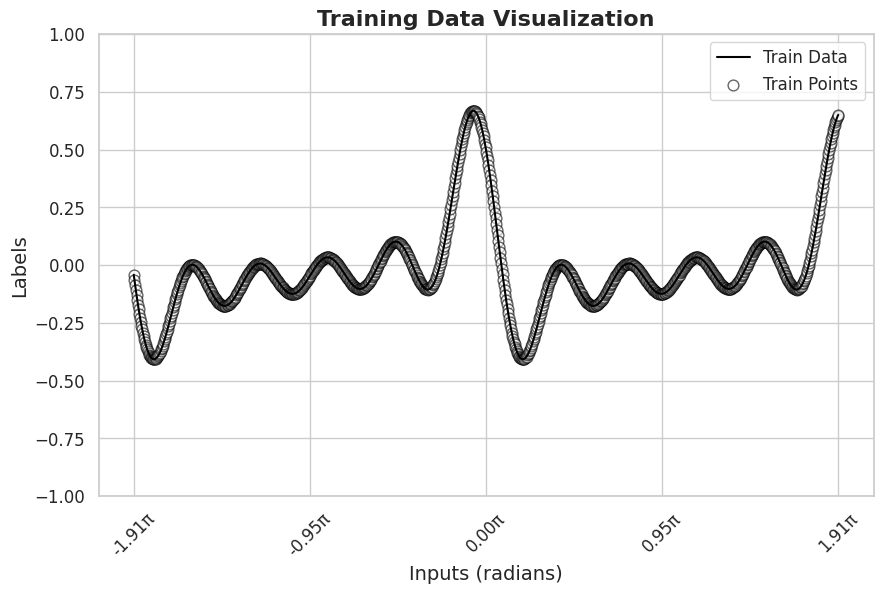

In [6]:
import pennylane.numpy as np
from modules.utils import create_data_advance_function
np.random.seed(16)

scaling = 1
degree = 5
coeffs = [0.05 + 0.05j]*degree
coeff0 = 0.0

X_train, Y_train = create_data_advance_function(1000, coeff0, coeffs, start=-6,stop=6)

Here we demonstrate what the system looks like.

0.15414287150369038


(<Figure size 1400x200 with 1 Axes>, <Axes: >)

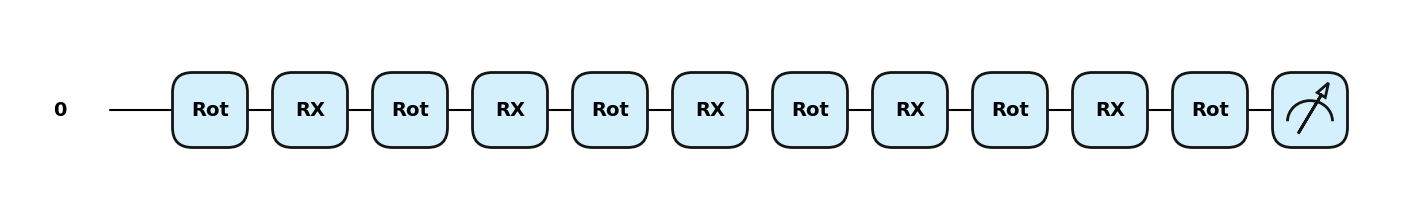

In [7]:
import  pennylane.numpy as np
import pennylane as qml
from modules.Circuit2 import quantum_circuit_2

r=1
L = 5
weights = 0.01* np.random.randn(L+1,1,3,requires_grad=True)
print(quantum_circuit_2(X_train[0],weights))
qml.draw_mpl(quantum_circuit_2,style='pennylane')(X_train[0],weights)


We can see that we have 5 layers. Each layer consists of an encoding block $S(x)$ and a trainable block. Our training block $W^{(l)}$ consists of arbitrary single qubit rotations (`qml.Rot` - description of this operation is in the 'Variational_Classifier' notebook in Task 2). In summary, we have 6 parameterized rotation gates and 5 encoding `RX` gates.
Our model, which we are training, has 18 trainable parameters.

<a id="3"></a>
#### Experiment 1

In this experiment, we train our model with the specified parameters:
* `num_qubits = 1 #r - number of qubits`
* `num_layers = 5 #L - number of layers`
* `learning rate = 0.01`
* `weights_init = 2*np.pi*np.random.randn(num_layers+1,num_qubits,3,requires_grad=True)`

Additionally, we modify the loss function slightly. We multiply our loss function by a factor of $1/2$. Adding the $1/2$ factor is common practice for simplifying the gradient during backpropagation, it's not strictly necessary for the loss function itself to function correctly.

Gradients and Optimization

Given the loss function:

$$L = \frac{1}{2N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$

The derivative with respect to a prediction $\hat{y}_i$ is:

$$
\frac{\partial L}{\partial \hat{y}_i} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)$$

Without the $\frac{1}{2}$ factor, the derivative would be:
$$
\frac{\partial L}{\partial \hat{y}_i} = \frac{2}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)$$
The gradients are scaled down by a factor of $2$ when we include the $\frac{1}{2}$ factor in the loss function.
It is important to note, that this can  influence the learning process, particularly with regard to the learning rate.

In [8]:
import pennylane as qml
import pennylane.numpy as np
from modules.training import training_circuit_2

num_qubits = 1 #r
num_layers = 5 #L
weights_init = 2*np.pi*np.random.randn(num_layers+1,num_qubits,3,requires_grad=True)

num_epochs = 300
opt = qml.AdamOptimizer(0.01)
batch_size = 25

final_params,costs = training_circuit_2(num_epochs,opt,weights_init, X_train,Y_train,batch_size)

Epoch: 10 | Cost: 0.1200624
Epoch: 20 | Cost: 0.0531002
Epoch: 30 | Cost: 0.0761284
Epoch: 40 | Cost: 0.0587386
Epoch: 50 | Cost: 0.0332073
Epoch: 60 | Cost: 0.0493333
Epoch: 70 | Cost: 0.0537844
Epoch: 80 | Cost: 0.0744579
Epoch: 90 | Cost: 0.0339004
Epoch: 100 | Cost: 0.0215094
Epoch: 110 | Cost: 0.0108647
Epoch: 120 | Cost: 0.0090586
Epoch: 130 | Cost: 0.0114622
Epoch: 140 | Cost: 0.0128846
Epoch: 150 | Cost: 0.0080510
Epoch: 160 | Cost: 0.0184285
Epoch: 170 | Cost: 0.0126196
Epoch: 180 | Cost: 0.0118192
Epoch: 190 | Cost: 0.0121431
Epoch: 200 | Cost: 0.0124133
Epoch: 210 | Cost: 0.0065482
Epoch: 220 | Cost: 0.0073821
Epoch: 230 | Cost: 0.0139621
Epoch: 240 | Cost: 0.0090704
Epoch: 250 | Cost: 0.0107745
Epoch: 260 | Cost: 0.0157708
Epoch: 270 | Cost: 0.0131466
Epoch: 280 | Cost: 0.0092255
Epoch: 290 | Cost: 0.0068163
Epoch: 300 | Cost: 0.0077902
Final parameters:  [[[ -6.78683891  16.20643657  -2.18064341]]

 [[ -0.92392973   1.44770687  10.35041271]]

 [[  5.01036386   4.34043653  

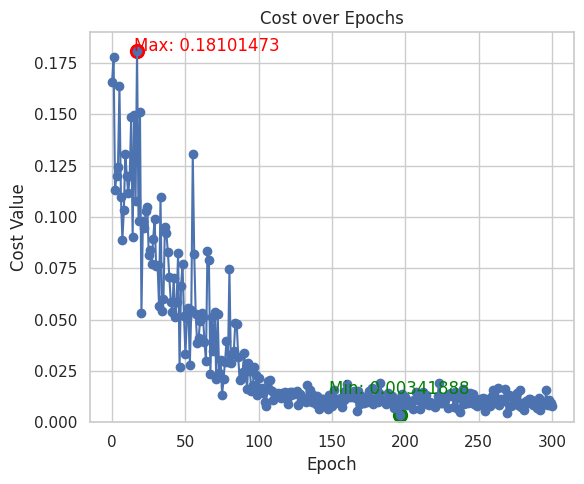

In [9]:
from modules.utils import plot_metrics_over_epochs
metrics_dict = {
    'Cost': costs
}
plot_metrics_over_epochs(metrics_dict)

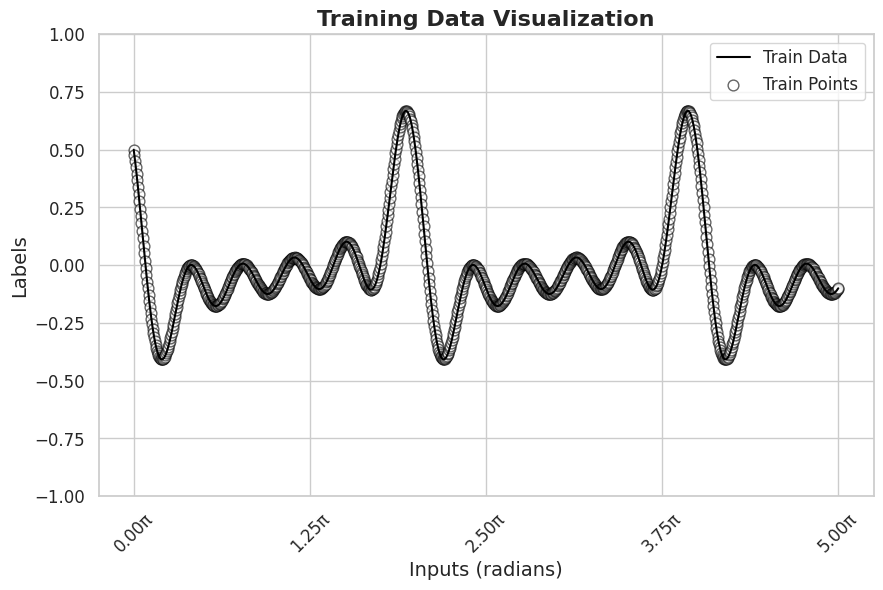

Cost (MSE) for training set: 0.0077902
Cost (MSE) for test set: 0.0110459


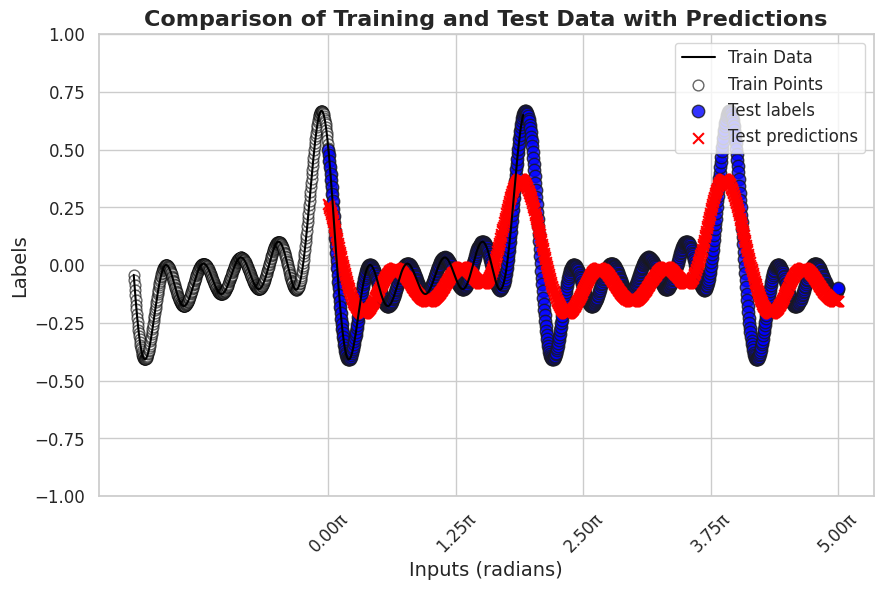

In [10]:
from modules.utils import plot_result
from modules.training import cost
from modules.Circuit2 import quantum_circuit_2

X_test, Y_test = create_data_advance_function(1000, coeff0, coeffs, start=0,stop=5*np.pi)

test_cost = cost(final_params, X_test, Y_test)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = predictions = [quantum_circuit_2(x=x_,weights=final_params) for x_ in X_test]

plot_result("Comparison of Training and Test Data with Predictions", X_test, Y_test, "Test labels", test_predictions, X_train, Y_train)

While the model demonstrates learning capabilities, the current results are not satisfactory. To enhance the performance, we propose adjusting the hyperparameters.
Specifically, we will increase the learning rate to 0.1 and reduce the number of epochs. Additionally, we will modify the initialization strategy for the initial parameters.

The logs of this training are saved in the file `Exp_0.01_batch_25_300.txt` in folder `experiments`.

<a id="5"></a>
#### Experiment 2
Comparing to the previous training process, we made the following changes to the parameters:
* `learning rate: 0.1`
* `weights_init= 0.01 * np.random.randn(num_layers+1, num_qubits, 3, requires_grad=True)`
* `num_epochs = 200`

In [11]:
import pennylane as qml
import pennylane.numpy as np
from modules.training import training_circuit_2

num_qubits = 1 #r
num_layers = 5 #L
weights_init= 0.01 * np.random.randn(num_layers+1, num_qubits, 3, requires_grad=True)

num_epochs = 200
opt = qml.AdamOptimizer(0.1)
batch_size = 25

final_params,costs_2 = training_circuit_2(num_epochs,opt,weights_init, X_train,Y_train,batch_size)

Epoch: 10 | Cost: 0.0252622
Epoch: 20 | Cost: 0.0106077
Epoch: 30 | Cost: 0.0039454
Epoch: 40 | Cost: 0.0077379
Epoch: 50 | Cost: 0.0058538
Epoch: 60 | Cost: 0.0026495
Epoch: 70 | Cost: 0.0019141
Epoch: 80 | Cost: 0.0013476
Epoch: 90 | Cost: 0.0002757
Epoch: 100 | Cost: 0.0004745
Epoch: 110 | Cost: 0.0000670
Epoch: 120 | Cost: 0.0001167
Epoch: 130 | Cost: 0.0000547
Epoch: 140 | Cost: 0.0000135
Epoch: 150 | Cost: 0.0000010
Epoch: 160 | Cost: 0.0000026
Epoch: 170 | Cost: 0.0000021
Epoch: 180 | Cost: 0.0000017
Epoch: 190 | Cost: 0.0000015
Epoch: 200 | Cost: 0.0000008
Final parameters:  [[[ 0.00399242  0.40916624 -0.95505222]]

 [[-0.85057903 -0.28333624 -0.81281764]]

 [[-0.43916555  0.37385751 -0.4869316 ]]

 [[ 0.365151   -0.69926417  0.70065615]]

 [[-0.52069851  0.09343852 -0.57955849]]

 [[-0.48651706 -0.55607633  0.00346522]]]


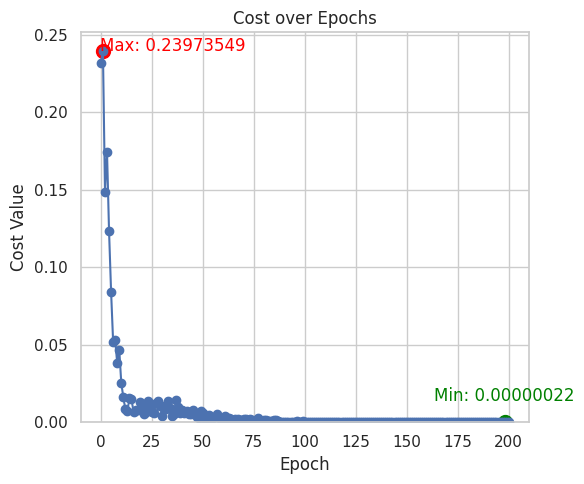

In [12]:
from modules.utils import plot_metrics_over_epochs
metrics_dict = {
    'Cost': costs_2
}
plot_metrics_over_epochs(metrics_dict)

The "Cost over Epochs" plot provides a visual representation of the training process:
* Initial Learning Phase: The cost value rapidly decreases during the initial epochs, showcasing effective learning and optimization.
* Convergence: The cost value swiftly converges to a very low value, indicating that the model achieves high accuracy early in the training process.

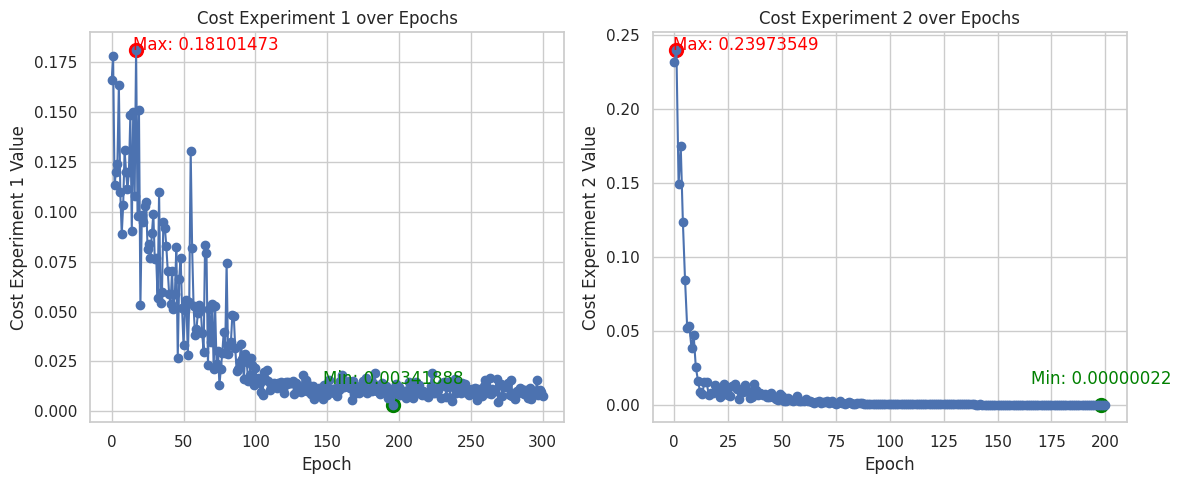

In [13]:
from modules.utils import plot_metrics_over_epochs
metrics_dict = {
    'Cost Experiment 1': costs,
    'Cost Experiment 2': costs_2
}
plot_metrics_over_epochs(metrics_dict)


This model reaches a stable, low cost value within approximately 70 epochs (comparable to the cost function in [Experiment 1](#4)), suggesting that it has a high capacity and is well-suited for the given problem. The stability of the cost value in subsequent epochs indicates that the model maintains its performance without overfitting.


We generated the test set within the interval $[0,5π]$. This interval differs from that of the training set to evaluate the model's ability to generalize its predictions. Specifically, this approach helps determine whether the model is capable of extrapolating accurately beyond the training data, thereby assessing its robustness and mitigating concerns of overfitting.

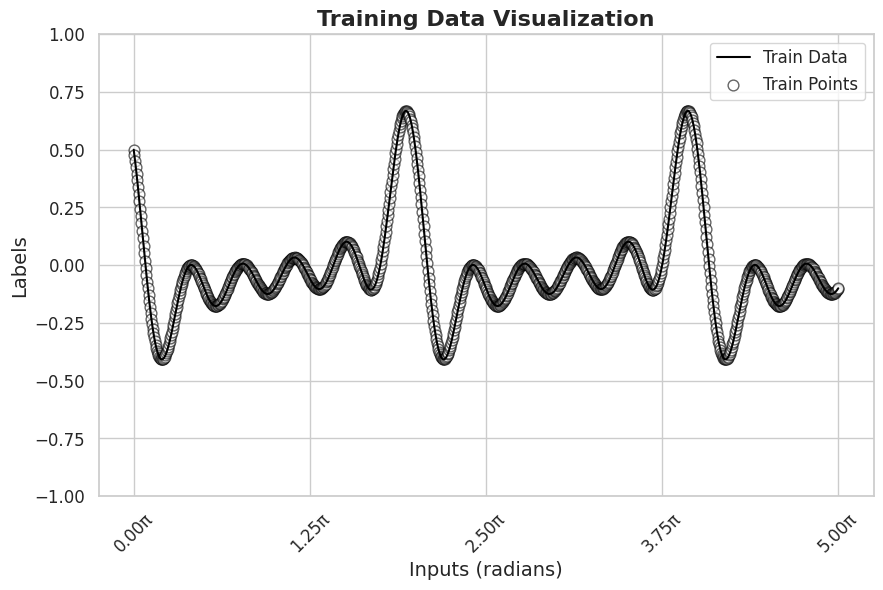

Cost (MSE) for training set: 0.0077902
Cost (MSE) for test set: 0.0000009


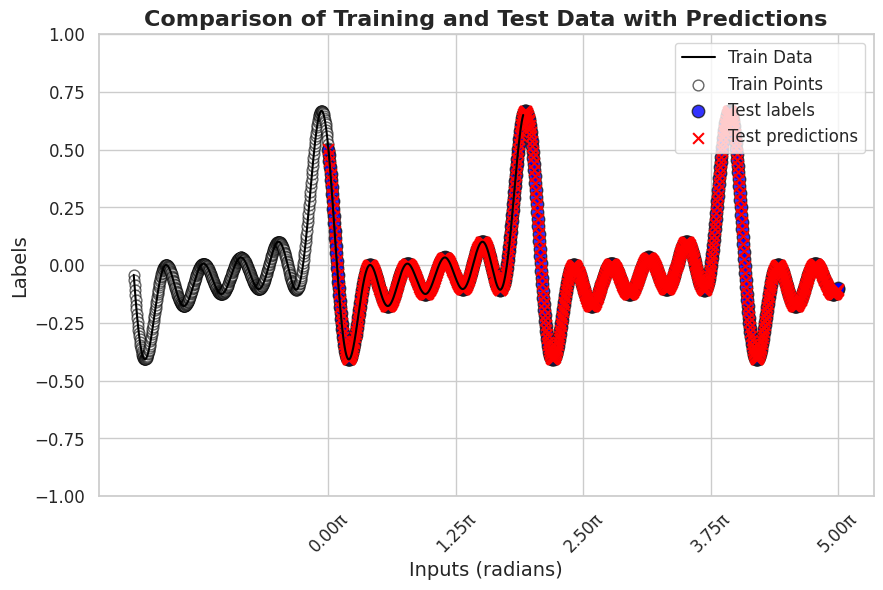

In [14]:
from modules.utils import plot_result
from modules.training import cost
from modules.Circuit2 import quantum_circuit_2

X_test, Y_test = create_data_advance_function(1000, coeff0, coeffs, start=0,stop=5*np.pi)

test_cost = cost(final_params, X_test, Y_test)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = predictions = [quantum_circuit_2(x=x_,weights=final_params) for x_ in X_test]

plot_result("Comparison of Training and Test Data with Predictions", X_test, Y_test, "Test labels", test_predictions, X_train, Y_train)


The presented plots evaluate the performance of a Variational Quantum Circuit (VQC) model in fitting a dataset. The x-axis in the primary plot represents the input values in radians, while the y-axis shows the corresponding labels: train data, test data and prediction.
The primary plot demonstrates that the VQC model's predictions closely align with the true test data, indicating a high level of accuracy. Model Performance metrics ($0.0000057$ for training set and $0.0000052$ testing set) suggest that the model effectively minimizes the error, achieving high accuracy on both the training and test sets.

The logs of this training are saved in the file `Exp_0.1_batch_25_200.txt` in folder `experiments`.


<a id="6"></a>
#### Experiment 3
We changed the function, but did not increase the frequency spectrum.

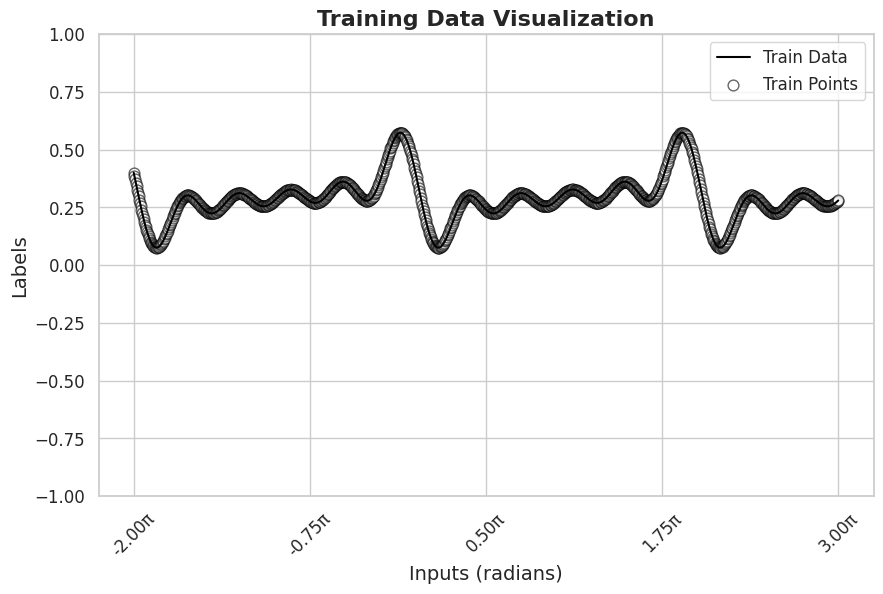

In [15]:
import pennylane.numpy as np
from modules.utils import create_data_advance_function
np.random.seed(16)

scaling = 1
degree = 5
coeffs = [0.01 + 0.03j]*degree
coeff0 = 0.3

X_train, Y_train = create_data_advance_function(1000, coeff0, coeffs, start=-2*np.pi,stop=3*np.pi, scaling=scaling)

In [16]:
import pennylane as qml
import pennylane.numpy as np
from modules.training import training_circuit_2

num_qubits = 1 #r
num_layers = 5 #L
weights_init= 0.01 * np.random.randn(num_layers+1, num_qubits, 3, requires_grad=True)

num_epochs = 300
opt = qml.AdamOptimizer(0.1)
batch_size = 32

final_params,costs = training_circuit_2(num_epochs,opt,weights_init, X_train,Y_train,batch_size)

Epoch: 10 | Cost: 0.0474298
Epoch: 20 | Cost: 0.0395940
Epoch: 30 | Cost: 0.0068352
Epoch: 40 | Cost: 0.0047986
Epoch: 50 | Cost: 0.0039441
Epoch: 60 | Cost: 0.0023008
Epoch: 70 | Cost: 0.0029106
Epoch: 80 | Cost: 0.0021809
Epoch: 90 | Cost: 0.0021226
Epoch: 100 | Cost: 0.0008587
Epoch: 110 | Cost: 0.0017083
Epoch: 120 | Cost: 0.0022334
Epoch: 130 | Cost: 0.0018616
Epoch: 140 | Cost: 0.0012557
Epoch: 150 | Cost: 0.0015557
Epoch: 160 | Cost: 0.0012833
Epoch: 170 | Cost: 0.0011724
Epoch: 180 | Cost: 0.0004943
Epoch: 190 | Cost: 0.0005342
Epoch: 200 | Cost: 0.0003313
Epoch: 210 | Cost: 0.0001079
Epoch: 220 | Cost: 0.0002106
Epoch: 230 | Cost: 0.0003398
Epoch: 240 | Cost: 0.0002206
Epoch: 250 | Cost: 0.0001454
Epoch: 260 | Cost: 0.0000737
Epoch: 270 | Cost: 0.0001734
Epoch: 280 | Cost: 0.0001725
Epoch: 290 | Cost: 0.0001226
Epoch: 300 | Cost: 0.0002759
Final parameters:  [[[ 1.27948718e-03  6.99233925e-01 -1.15261533e+00]]

 [[-1.02203012e+00  1.21402756e-02 -9.71861909e-01]]

 [[-1.486343

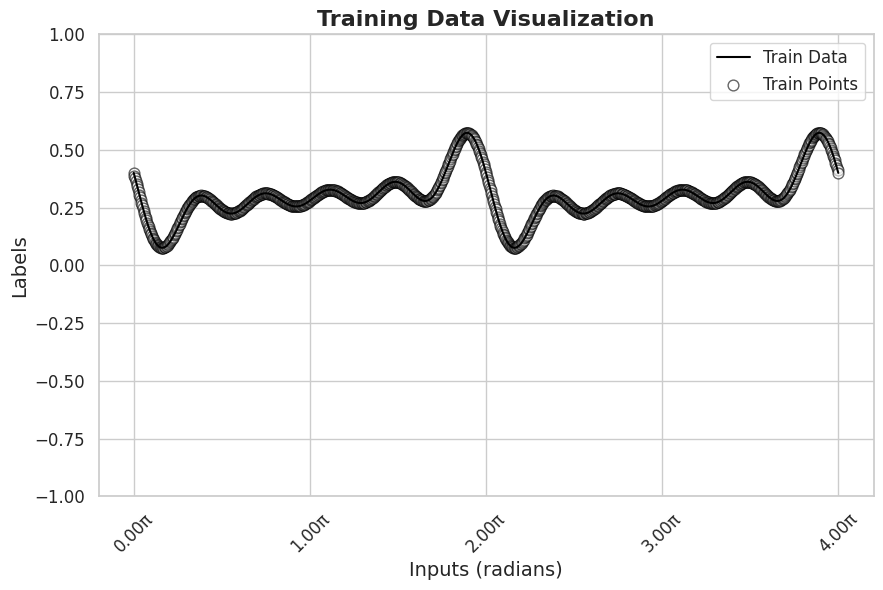

Cost (MSE) for training set: 0.0002759
Cost (MSE) for test set: 0.0002641


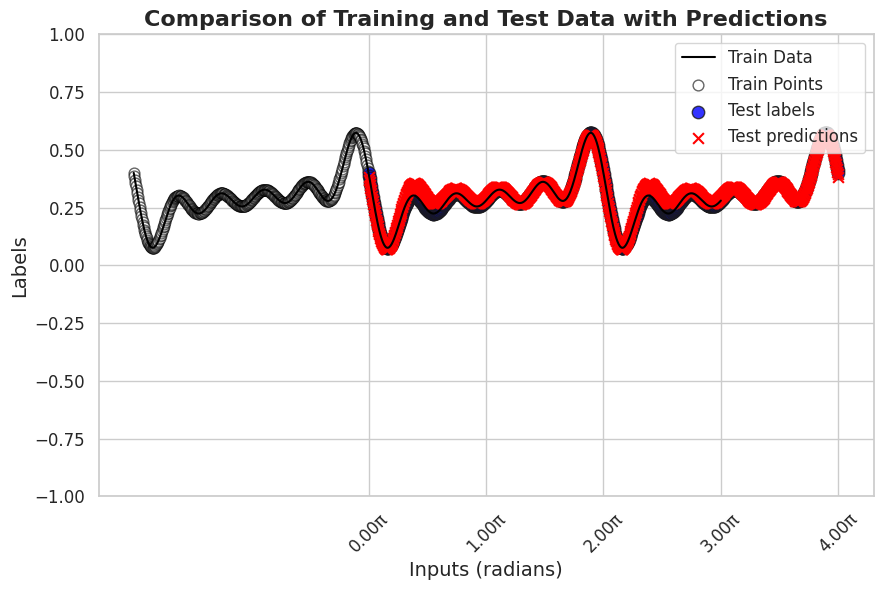

In [17]:
from modules.utils import plot_result
from modules.training import cost
from modules.Circuit2 import quantum_circuit_2

X_test, Y_test = create_data_advance_function(1000, coeff0, coeffs, start=0,stop=4*np.pi)

test_cost = cost(final_params, X_test, Y_test, scaling=scaling)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = predictions = [quantum_circuit_2(x=x_,weights=final_params) for x_ in X_test]

plot_result("Comparison of Training and Test Data with Predictions", X_test, Y_test, "Test labels", test_predictions, X_train, Y_train)

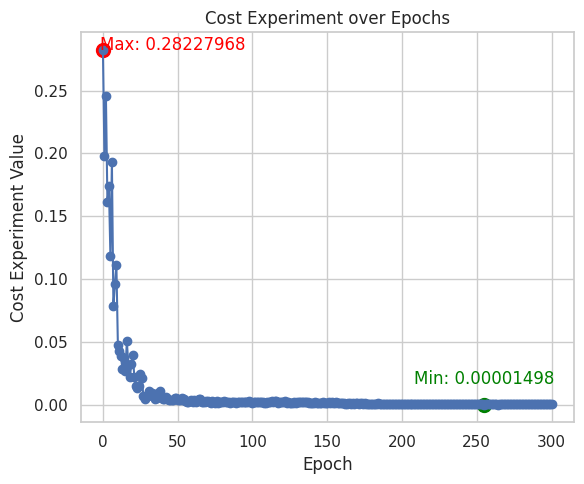

In [18]:
from modules.utils import plot_metrics_over_epochs
metrics_dict = {
    'Cost Experiment': costs,
}
plot_metrics_over_epochs(metrics_dict)

<a id="7"></a>
#### Experiment 4
Now, we extend the frequency spectrum.

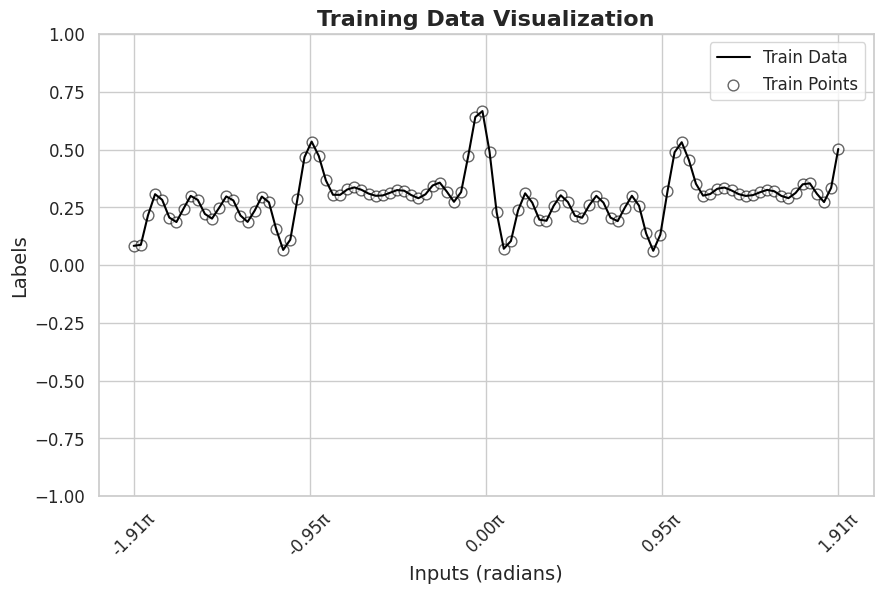

In [19]:
import pennylane.numpy as np
from modules.utils import create_data_advance_function
np.random.seed(16)

scaling = 1
degree = 10
coeffs = [0.01 + 0.03j,0.02 + 0.00j]*5
coeff0 = 0.3

X_train, Y_train = create_data_advance_function(100, coeff0, coeffs, start=-6,stop=6, scaling=scaling)

In [20]:
import pennylane as qml
import pennylane.numpy as np
from modules.training import training_circuit_2

num_qubits = 1 #r
num_layers = 5 #L
weights_init= 0.01 * np.random.randn(num_layers+1, num_qubits, 3, requires_grad=True)

num_epochs = 300
opt = qml.AdamOptimizer(0.1)
batch_size = 32

final_params,costs = training_circuit_2(num_epochs,opt,weights_init, X_train,Y_train,batch_size)

Epoch: 10 | Cost: 0.0442733
Epoch: 20 | Cost: 0.0130874
Epoch: 30 | Cost: 0.0062020
Epoch: 40 | Cost: 0.0053287
Epoch: 50 | Cost: 0.0048540
Epoch: 60 | Cost: 0.0034807
Epoch: 70 | Cost: 0.0070470
Epoch: 80 | Cost: 0.0040229
Epoch: 90 | Cost: 0.0050821
Epoch: 100 | Cost: 0.0062223
Epoch: 110 | Cost: 0.0055530
Epoch: 120 | Cost: 0.0060379
Epoch: 130 | Cost: 0.0037185
Epoch: 140 | Cost: 0.0060207
Epoch: 150 | Cost: 0.0039561
Epoch: 160 | Cost: 0.0042436
Epoch: 170 | Cost: 0.0035497
Epoch: 180 | Cost: 0.0036481
Epoch: 190 | Cost: 0.0024737
Epoch: 200 | Cost: 0.0052531
Epoch: 210 | Cost: 0.0028162
Epoch: 220 | Cost: 0.0035792
Epoch: 230 | Cost: 0.0025450
Epoch: 240 | Cost: 0.0033493
Epoch: 250 | Cost: 0.0046934
Epoch: 260 | Cost: 0.0047118
Epoch: 270 | Cost: 0.0032333
Epoch: 280 | Cost: 0.0055938
Epoch: 290 | Cost: 0.0032394
Epoch: 300 | Cost: 0.0048534
Final parameters:  [[[ 1.27948741e-03  1.49042614e-01  3.24598839e-01]]

 [[-7.49335756e-01 -1.62485219e-01 -7.79467515e-01]]

 [[-9.543259

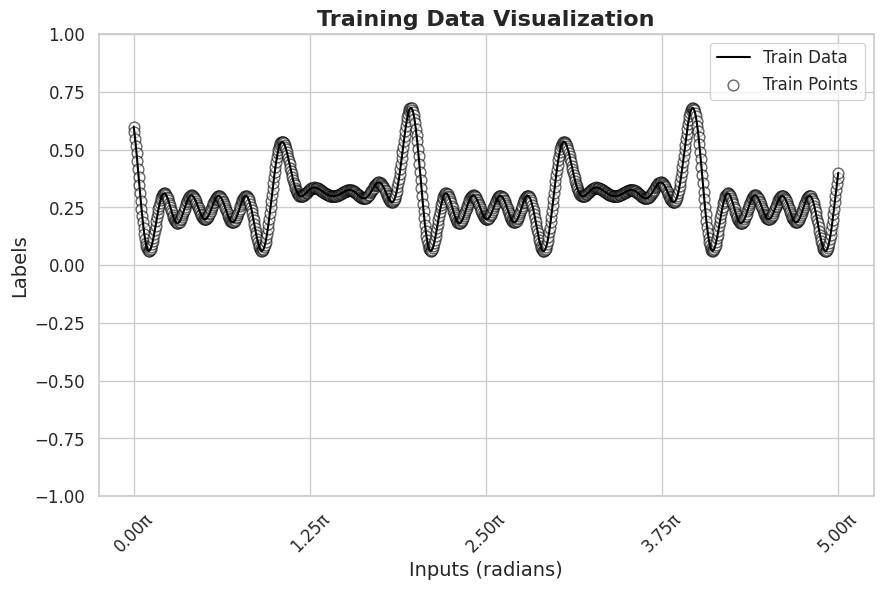

Cost (MSE) for training set: 0.0048534
Cost (MSE) for test set: 0.0058973


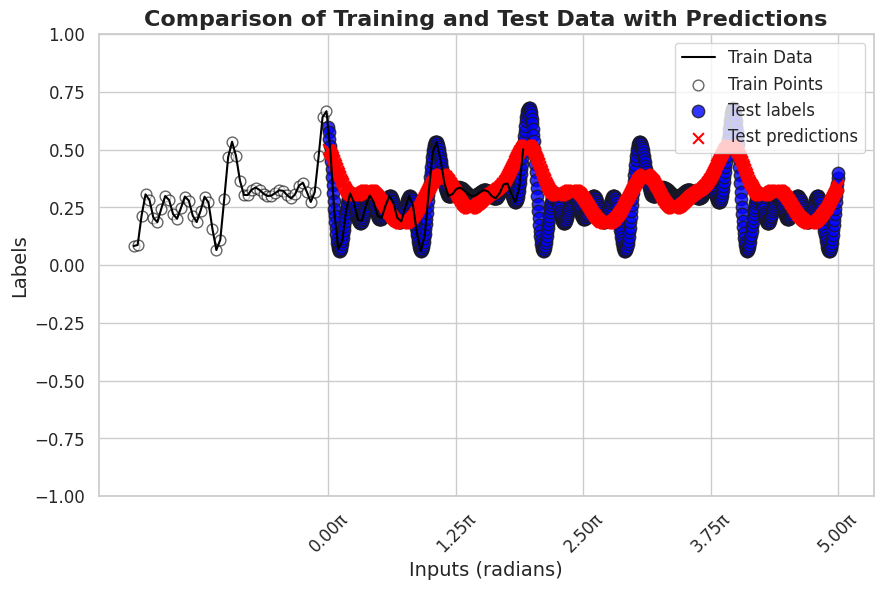

In [21]:
from modules.utils import plot_result
from modules.training import cost
from modules.Circuit2 import quantum_circuit_2

X_test, Y_test = create_data_advance_function(1000, coeff0, coeffs, start=0,stop=5*np.pi)

test_cost = cost(final_params, X_test, Y_test, scaling=scaling)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = predictions = [quantum_circuit_2(x=x_,weights=final_params) for x_ in X_test]

plot_result("Comparison of Training and Test Data with Predictions", X_test, Y_test, "Test labels", test_predictions, X_train, Y_train)